In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/jenna/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
# load kernel file
def loadSimilarities(fn):
    """
    Load the previously saved similarity matrix from a .npz file

    Inputs:
    - fn: directory/filename (minus extension) to load the file from

    Returns:
    - loadedSims: similarity matrix
    """
    loader = np.load(fn+".npz")
    print "Similarities loaded!"
    return loader['similarities']

kernelFN = "/home/jenna/Research/lung-image-analysis/code/simulatedData/kernel-matrix"
kernel = loadSimilarities(kernelFN)
# Note: loaded kernel is the result of
# - building the KNN graph using KL divergence
# - symmeterizing the graph: KL is not a distance and is not symmetric, we need distance-symmetry behavior because next step is...
# - passing the symmeterized graph through a radial basis function (RBF): Since the value of the RBF kernel decreases with distance and ranges between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure
# - projecting the output of the RBF to a positive semi-definite space: 

Similarities loaded!


In [9]:
# Helper functions
def evalFeatures_Regression(XTrain,yTrain,XTest,yTest,m):
    """
    evaluate a regression model
    """
    from sklearn import metrics
    from sklearn.preprocessing import StandardScaler

    # scaling
    stdScaler = StandardScaler()
    stdScaler.fit(XTrain)
    XTrain = stdScaler.transform(XTrain)
    yTrain = np.log10(yTrain)
    XTest = stdScaler.transform(XTest)
    yTest = np.log10(yTest)
        
    m.fit(XTrain, yTrain)
    pred_y = m.predict(XTest)
    r2 = metrics.r2_score(yTest, pred_y)
    s = metrics.mean_squared_error(yTest, pred_y)
    return r2, s

In [11]:
# cholesky factorization

# ============== cholesky
# K_PSD is the result of projection -> loaded kernel data
regParam =  1e-3
# perform the cholesky factorization
hidim = np.linalg.cholesky(kernel+(regParam*np.eye(kernel.shape[0])))

This is some information the projected kernel :
min, median, max value of the kernel: -0.212688 0.898131 1.82299
less than 0.3 :0.0963287113614
less than 0.5 :0.168948740856
less than 1.0 :0.697478416973
-----------
number of subject with at least one entry higher than 1: 7292
These are diagonal elements: [ 1.26771092  1.28703213  1.25610507 ...,  1.34241414  1.27499807
  1.31684828]


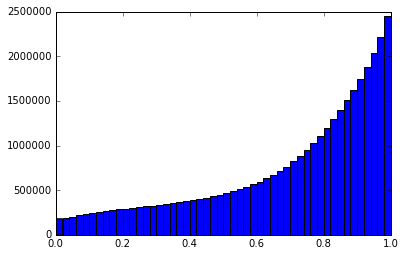

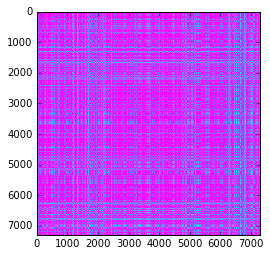

In [12]:
# Numerical checking
print "This is some information the projected kernel :"
print "min, median, max value of the kernel: " + str(np.min(kernel)) + " " + str(np.median(kernel)) +" "+ str(np.max(kernel))
print "less than 0.3 :" + str(np.sum(kernel.flatten() < 0.3)/np.float(np.prod(kernel.shape)))
print "less than 0.5 :" + str(np.sum(kernel.flatten() < 0.5)/np.float(np.prod(kernel.shape)))
print "less than 1.0 :" + str(np.sum(kernel.flatten() < 1)/np.float(np.prod(kernel.shape)))
print "-----------"
print "number of subject with at least one entry higher than 1: " + str( ((kernel > 1.0).sum(axis=0)>0).sum())
print "These are diagonal elements: " + str(np.diag(kernel))

plt.figure()
_ = plt.hist(kernel.flatten()[np.logical_and(kernel.flatten() < 1 , kernel.flatten() > 0) ],50)

plt.figure()
plt.imshow(kernel, vmin=0, vmax=1.0, cmap='cool')

In [13]:
# =================== embedding for patient
from sklearn import manifold

# transform the cholesky factorization into a set of 2D features to use in the visualization
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # 
tSNE = tsne.fit_transform(hidim)   # hidim is the cholesky factorization

#clf = LocallyLinearEmbedding(n_c omponents=d)
#tSNE = clf.fit_transform(hidim)    

# plot 2d embedding
import seaborn as sns

In [15]:
import pickle as pk

def loadSimSubjects(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - patients: loaded node/feature information
    - classes: number of abnormal nodes in the patient
    """
    with open(fn+".data.p", "rb") as f:
        loader = pk.load(f)
    f.close()
    print "Simluated patient data loaded!"
    return loader['patients'], loader['classes']

# load the list of the number of abnormal nodes for each subject
patientsFN = "/home/jenna/Research/lung-image-analysis/code/simulatedData/simulatedSubjects"
loadedSubjs, subjList = loadSimSubjects(patientsFN)
# get a list of permuted indices to use - not necessary?
permIdx = np.random.permutation(range(len(subjList)))
subjList_subset = np.array(subjList)[permIdx[:3000]]    
tSNE_subset = tSNE[permIdx[:3000]]

Simluated patient data loaded!


In [16]:
from mpl_toolkits.axes_grid1 import *

def  plotLowDimWithColor( nodes2D, subjColor, 
                         ax=None, plotTitle=None, markerSize=2 ):
    """
    plot low dimensional embedding
    
    Inputs:
    - nodes2D: subset of patients that came from a higher dimensional space and need to be plotted in 2D for visualization
    - subjColor: number of abnormal nodes in each simulated patient
    
    Returns: nothing
    Effect: plots a scatter plot
    """
    inFeature = nodes2D

    # normalize the colors to a good range
    maxVal = -np.sort(-np.asarray(subjColor))[0]
    minVal = np.sort(np.asarray(subjColor))[0]
    cm = plt.cm.get_cmap('RdYlBu_r')
    
    if ax==None:
        scatter(inFeature[:,0], inFeature[:,1], c=subjColor, 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize )
        colorbar()
        plt.xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        plt.ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0))   
        plt.title(plotTitle)      
    else:
        scPlot = ax.scatter(inFeature[:,0], inFeature[:,1], c=np.asarray(subjColor), 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize  )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scPlot, cax=cax)
        ax.set_xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        ax.set_ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0)) 
        ax.set_title(plotTitle)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

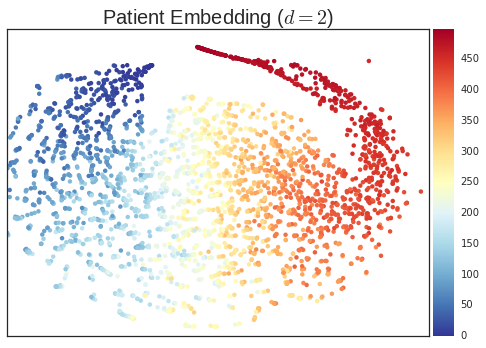

In [17]:
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# write your own visualizationb, each subject is a dot in 2D and color each subject with her own y
plotLowDimWithColor(tSNE_subset, subjList_subset, 
                    ax=ax1, plotTitle='tSNE', markerSize=20)

ax1.set_xlim([-11,11])
ax1.set_ylim([-11,11])
ax1.set_title('Patient Embedding ($d=2$)',fontsize=20)

In [18]:
# ========== extracting higher dim features per subject
from sklearn.manifold import LocallyLinearEmbedding

clf = LocallyLinearEmbedding(n_components=100)
LLE_modified = clf.fit_transform(hidim)   # this is your X, ie your feature per subject


In [20]:
# ======== Regression
numPCA_comp = 100
colNameList = []
for numDim in range(2,numPCA_comp,10):
    colNameList.append(['LLE_modified_f%d'%i for i in range(numDim)])

score_r2DictList = {}
p_r2DictList = {}
accScoreDictList = {}
p_accDictList = {}    
    
featureName = 'histFHOG_largeRange_setting1'
score_r2DictList[featureName] = []
p_r2DictList[featureName] = []
accScoreDictList[featureName] = []
p_accDictList[featureName] = []

In [21]:
from sklearn import linear_model
import time
from skl_groups.features import Features
from skl_groups.summaries import BagOfWords
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold

for colName in colNameList:
    #---------------------  Compute BOW
    t0 = time.clock()
    print "computing bag of words ......"
    feats = Features(loadedSubjs)      # here the data is your patient patch data - list of patch features
    bow = BagOfWords(KMeans(n_clusters=len(colName), max_iter=100, n_init=2))
    bowized = bow.fit_transform(feats)
    print "Done !"
    print time.time() - t0

    # make dataframe for the LLE features
#     LLE_modified_df = pd.DataFrame(LLE_modified[:,0:len(colName)],
#                                    columns=['LLE_modified_f%d'%i for i in range(len(colName))])
#     LLE_modified_df['sid'] = subjList

    # make dataframe out of BOW
    BOW_df = pd.DataFrame(bowized,columns=['BOW_f%d'%i for i in range(bowized.shape[1])])
    BOW_df['sid'] = ["S"+str(i).zfill(4)

    # merge two dataframes
#     complete_db = pd.merge(phenotypeDB_clean, LLE_modified_df, left_on='sid',right_on='sid')
#     complete_db = pd.merge(complete_db, BOW_df, left_on='sid',right_on='sid')
#     complete_db_clean = complete_db.dropna(subset=['Insp_Below950_Slicer','Exp_Below950_Slicer'])

    # make a cross-validation object
    cv = KFold(n=len(loadedSubjs), 
               n_folds=50, shuffle=False, random_state=0)

 
    ### regression
    allXy = {}    
    yName = 'FEV1pp_utah'
    

#     allXy['SimulatedNNFeats'] = (X,y)
#     allXy['BOW'] = (bowized,y)
    allXy['SimulatedNNFeats'] = (LLE_modified,np.asarray(subjList))   # is X supposed to be the patch features?
    allXy['BOW'] = (bowized,np.asarray(subjList))    # replaced y with subjList


    score_r2Dict = {}
    p_r2Dict = {}
    for k in allXy.keys():         
        #clf = linear_model.Ridge(alpha=1)
        score_r2Dict[k] = [] 
        #score_r2Dict[k] = cross_val_score(clf, allXy[k][0], allXy[k][1], cv=50, scoring='r2_score')
        print "working on ",k, "...."
        for i, (train, test) in enumerate(cv):
            clf = linear_model.Ridge(alpha=1)
            r2,s = evalFeatures_Regression(allXy[k][0][train],    # your X (LLE_modified)
                                           allXy[k][1][train],    # your y 
                                           allXy[k][0][test],     # your X
                                           allXy[k][1][test],clf) # your y
            score_r2Dict[k].append(r2)


    print "****** R2 ********* : dim : ", len(colName) 
    for k in allXy.keys():
        _,p = scipy.stats.ttest_rel(np.array(score_r2Dict[k]), 
                              np.array(score_r2Dict['classic']))              
        p_r2Dict[k] = p
        print('MEAN R2 for %s (Ridge Reg):    %f (%f) -- pVal: %.3e'%\
              (k,np.mean(score_r2Dict[k]), np.std(score_r2Dict[k]),p) )  

    # add the results to a list
    score_r2DictList[featureName].append(score_r2Dict)
    p_r2DictList[featureName].append(p_r2Dict)
    accScoreDictList[featureName].append(accScoreDict)
    p_accDictList[featureName].append(p_accDict)
    


pk.dump( score_r2DictList, open(hellingerRoot + "/linReg_score_r2DictList.p",'wb') )
pk.dump( p_r2DictList, open(hellingerRoot + "/linReg_p_r2DictList.p",'wb') )
pk.dump( accScoreDictList, open(hellingerRoot + "/linReg_accScoreDictList.p",'wb') )
pk.dump( p_accDictList, open(hellingerRoot + "/linReg_p_accDictList.p",'wb') )

computing bag of words ......
Done !
1480626624.36


NameError: name 'pd' is not defined

In [ ]:
# plot 
# compute average of the 50 folds for all 

<type 'list'>


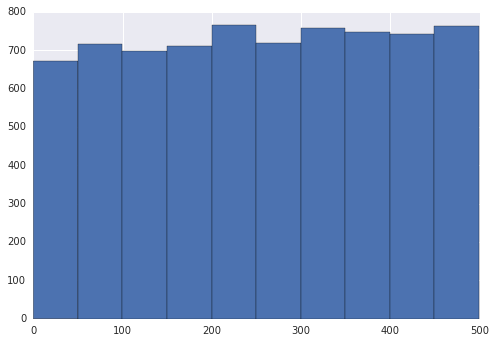

In [110]:
# Figures for Vanathi
# histogram of how many abnormal nodes are present in each subject
plt.figure()
plt.hist(subjList)

allXy = {}    
yName = 'FEV1pp_utah'

allXy['SimulatedNNFeats'] = (LLE_modified,subjList)   # is X supposed to be the patch features?
allXy['BOW'] = (bowized,subjList)    # replaced y with subjList
print type(allXy['SimulatedNNFeats'][1])